# **Pycaret**

## **Librerías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from pycaret.classification import *

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## **Datos**

In [5]:
df = pd.read_csv('./Datos/Model_Data.csv')

In [6]:
X = df.drop('Transported', axis=1)
y = df[['Transported']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 31)

In [8]:
df_train = pd.merge(X_train.reset_index(), y_train.reset_index()).drop('index', axis=1)
df_test = pd.merge(X_test.reset_index(), y_test.reset_index()).drop('index', axis=1)

## **Modelamiento**

In [9]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Cabin_Type', 'Cabin_Type_2', 'Earth', 'Europa', 'Mars', '55 Cancri e',
       'PSO J318.5-22', 'TRAPPIST-1e', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T',
       'P', 'S', 'Transported'],
      dtype='object')

In [96]:
setup_output = setup(
    session_id = 6747,
    data=df_train,
    target='Transported',
    ignore_features=[
        'PassengerId', 
        'HomePlanet',
        'Cabin',
        'Destination',
        'Cabin_Type',
        'Cabin_Type_2'
    ],
    fold = 5,
    #imputation_type='iterative',
    fold_strategy = 'kfold',
    feature_selection = True,
    remove_multicollinearity = True,
    #group_features = [
        #['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Age'],
    #],
    feature_ratio=True,
    feature_interaction=True,
    fix_imbalance=True,
    combine_rare_levels=True
)

,Description,Value
0,session_id,6747
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6085, 31)"
5,Missing Values,False
6,Numeric Features,6
7,Categorical Features,18
8,Ordinal Features,False
9,High Cardinality Features,False


### **Entrenamiento**

In [91]:
8028

8028

In [97]:
%%time
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8028,0.8869,0.8048,0.8029,0.8034,0.6053,0.6060,0.1220
gbc,Gradient Boosting Classifier,0.7950,0.8853,0.8162,0.7839,0.7996,0.5899,0.5906,0.4100
rf,Random Forest Classifier,0.7920,0.8651,0.7549,0.8164,0.7842,0.5839,0.5858,0.2780
lr,Logistic Regression,0.7894,0.8788,0.8125,0.7773,0.7944,0.5786,0.5795,0.3960
ada,Ada Boost Classifier,0.7812,0.8713,0.8088,0.7674,0.7874,0.5622,0.5633,0.1640
et,Extra Trees Classifier,0.7807,0.8470,0.7296,0.8140,0.7692,0.5614,0.5648,0.3000
lda,Linear Discriminant Analysis,0.7788,0.8606,0.7192,0.8176,0.7651,0.5576,0.5619,0.0640
ridge,Ridge Classifier,0.7784,0.0000,0.7192,0.8168,0.7648,0.5567,0.5609,0.0480
knn,K Neighbors Classifier,0.7680,0.8424,0.7712,0.7674,0.7691,0.5359,0.5361,0.2140
nb,Naive Bayes,0.7610,0.8494,0.8471,0.7238,0.7801,0.5217,0.5304,0.0400


CPU times: total: 5.17 s
Wall time: 15.7 s


In [98]:
best_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=6747, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### **HiperParametros**

In [99]:
%%time
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7864,0.8742,0.7606,0.8020,0.7807,0.5728,0.5735
1,0.8134,0.8875,0.8118,0.8137,0.8127,0.6268,0.6268
2,0.7934,0.8772,0.8226,0.7829,0.8022,0.5863,0.5871
3,0.7981,0.8825,0.7775,0.8117,0.7943,0.5963,0.5968
4,0.7979,0.8752,0.7915,0.7990,0.7952,0.5957,0.5957
Mean,0.7978,0.8793,0.7928,0.8019,0.7970,0.5956,0.5960
Std,0.0089,0.0050,0.0225,0.0110,0.0105,0.0178,0.0175


CPU times: total: 2.27 s
Wall time: 14.6 s


In [100]:
tuned_best_model

LGBMClassifier(bagging_fraction=0.9, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.005, max_depth=-1,
               min_child_samples=1, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=70, n_jobs=-1, num_leaves=90, objective=None,
               random_state=6747, reg_alpha=1, reg_lambda=0.2, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### **Feature Importance**

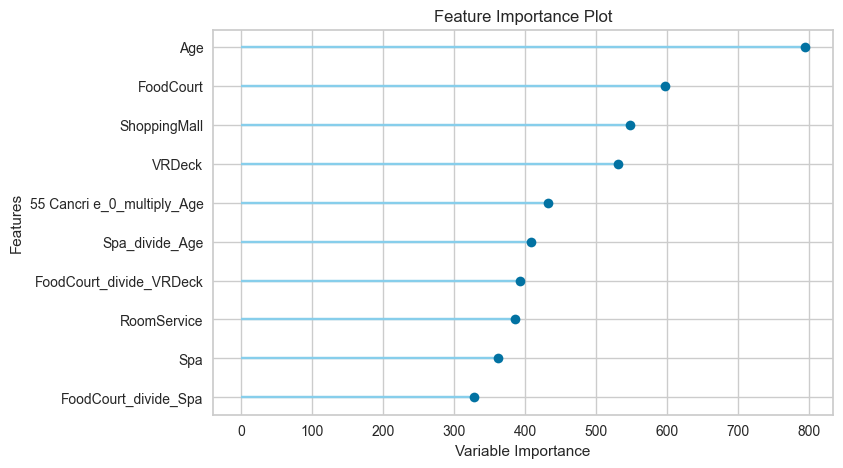

In [101]:
plot_model(tuned_best_model, plot='feature')

### **Matriz de Confusión**

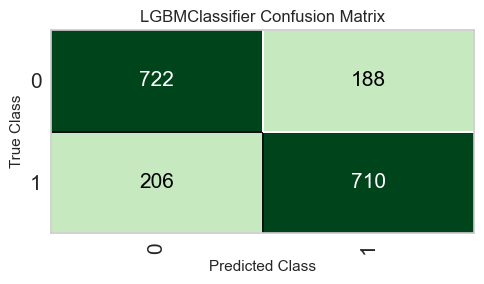

In [102]:
plt.subplots(figsize = (5, 3))
plot_model(tuned_best_model, plot='confusion_matrix')

## **Validación**

In [107]:
prediction = predict_model(tuned_best_model, data = X_test)

In [108]:
y_pred = prediction['Label']

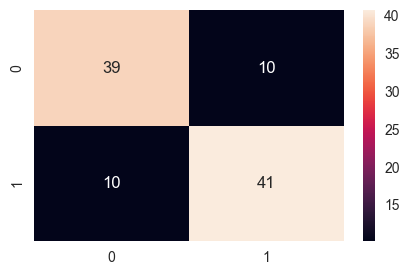

In [109]:
plt.subplots(figsize=(5,3))
sns.heatmap(confusion_matrix(y_test, y_pred)/len(y_test)*100, annot=True)
plt.show()

In [110]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1280
           1       0.80      0.80      0.80      1328

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



## **Resultados**

In [111]:
test_kaggle = pd.read_csv('./Datos/test.csv')

In [112]:
test_kaggle.sample()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
3991,8697_01,Earth,True,G/1401/S,PSO J318.5-22,25.0,False,0.0,0.0,0.0,0.0,0.0,Milyla Fowles


### **Limpieza y Preparación de Datos**

In [113]:
# Planeta natal
test_kaggle['HomePlanet'].fillna('Unknown', inplace=True)

# Sueño criogenico
test_kaggle['CryoSleep'].fillna('Unknown', inplace=True)

In [114]:
def calc_detail_cabin(x, position):
    # Divides la cadena en subcadenas utilizando '/' como separador y devuelve el primer elemento
    try:
        return x.split('/')[position]        
    # Si ocurre algún error al intentar dividir la cadena, se devuelve la cadena original
    except:
        return x

In [115]:
# Información de la cabina
test_kaggle['Cabin'].fillna('Unknown', inplace=True)
test_kaggle['Cabin_Type'] = test_kaggle['Cabin'].apply(lambda x: calc_detail_cabin(x, 0))
test_kaggle['Cabin_Type_2'] = test_kaggle['Cabin'].apply(lambda x: calc_detail_cabin(x, 2))

In [116]:
# Destino
test_kaggle['Destination'].fillna('Unknown', inplace=True)

In [117]:
#Edad
test_kaggle['Age'].fillna(round(test_kaggle['Age'].mean()), inplace=True)

In [118]:
# VIP
test_kaggle['VIP'].fillna('Unknown', inplace=True)

In [119]:
# Variables numéricas $$
test_kaggle['RoomService'].fillna(0, inplace=True)
test_kaggle['FoodCourt'].fillna(0, inplace=True)
test_kaggle['ShoppingMall'].fillna(0, inplace=True)
test_kaggle['Spa'].fillna(0, inplace=True)
test_kaggle['VRDeck'].fillna(0, inplace=True)

In [120]:
# Eliminamos el nombre
test_kaggle.drop('Name', axis= 1, inplace=True)

### **Preparando los datos para el modelo**

In [121]:
test_kaggle['CryoSleep'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)
test_kaggle['VIP'].replace([False, True, 'Unknown'], [0, 1, 0], inplace=True)

In [122]:
home_planet_dum = pd.get_dummies(test_kaggle['HomePlanet'])
destination_dum = pd.get_dummies(test_kaggle['Destination'])
cabin_I_dum = pd.get_dummies(test_kaggle['Cabin_Type'])
cabin_II_dum = pd.get_dummies(test_kaggle['Cabin_Type_2'])

In [123]:
X_kaggle = test_kaggle.drop(
    ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Cabin_Type', 'Cabin_Type_2'], 
    axis=1
)

In [124]:
X_kaggle = pd.merge(test_kaggle.reset_index(), home_planet_dum.reset_index(), how='left', left_on='index', right_on='index')
X_kaggle = pd.merge(X_kaggle, destination_dum.reset_index(), how='left', left_on='index', right_on='index')
X_kaggle = pd.merge(X_kaggle, cabin_I_dum.reset_index(), how='left', left_on='index', right_on='index')
X_kaggle = pd.merge(X_kaggle, cabin_II_dum.reset_index(), how='left', left_on='index', right_on='index')

In [125]:
X_kaggle.drop(['index', 'Unknown_x', 'Unknown_y', 'Unknown_x', 'Unknown_y'], axis=1, inplace=True)

In [131]:
prediction = predict_model(best_model, data = X_kaggle)

In [132]:
prediction['Label'] = np.where(prediction['Label'] == 1, True, False)

In [133]:
final = prediction[['PassengerId', 'Label']]

In [134]:
final.columns = ['PassengerId', 'Transported']

In [135]:
final.to_csv('./Datos/Resultados_008.csv', index=False)